## Тестирование прогнозов риска пожара обученной модели ResNet50 - `wildfire_prediction_resnet50.pth` - на основе спутниковых снимков

#### Датасет

- https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset

In [46]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

import os
from PIL import ImageFile

In [50]:
# импорт датасета из kaggle --- рекомендуется взять данные так, если запускать в colab ----

# import kagglehub
# path = kagglehub.dataset_download("abdelghaniaaba/wildfire-prediction-dataset")
# print("Path to dataset files:", path)

In [75]:
# датасет для прогнозирования пожаров
# path="wildfire_data_set_path" # путь к датасету  сохраненному локально
path="K:\\EducationCV\\first_year\\hackathon\\WildFire"

In [77]:
print("Path to dataset files:", path)

print(os.listdir(path+"/test"))

Path to dataset files: K:\EducationCV\first_year\hackathon\WildFire
['nowildfire', 'wildfire']


In [38]:
# загружаем уже тестовую выборку
test_path = path + "/test"
# Преобразуем в формат, понятный ResNet50
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Размер, который использует ResNet50
    transforms.ToTensor(),  # Переводим в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])

test_data = datasets.ImageFolder(root=test_path, transform=transform)

test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Classes: {test_data.classes}")  # Должно вывести ['nowildfire', 'wildfire']

Classes: ['nowildfire', 'wildfire']


In [64]:
# Определяем количество классов
num_classes = 2  # wildfire / no wildfire

# Создаём модель

# # проверяем, доступна ли в системе GPU (CUDA). Если да, то модель и данные будут загружены на GPU, если нет — будут использовать CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Заменяем последний слой

# Загружаем веса
model.load_state_dict(torch.load("wildfire_prediction_resnet50.pth", map_location=device)) # указывается путь и имя обученной модели
model.to(device)
model.eval()  # Переключаем в режим оценки

print("The model is loaded and ready")

cuda
The model is loaded and ready


In [42]:
# определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [44]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

test_loss = 0.0
correct = 0
total = 0

# Получаем предсказания и реальные метки
class_names = ["No Wildfire", "Wildfire"]
all_preds = []
all_labels = []

# Получаем вероятности для классов
all_probs = []

with torch.no_grad():  # Отключаем вычисление градиентов
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)  # Получаем предсказания
        loss = criterion(outputs, labels)  # Считаем loss
        test_loss += loss.item()

        # Получаем предсказанный класс (наибольшая вероятность)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Берём вероятность класса "Wildfire"
        all_probs.extend(probs.cpu().numpy())

print("Prediction completed")

Prediction completed


## Оценка качества модели

In [56]:
# Усредняем loss по количеству батчей
test_loss /= len(test_loader)
# Вычисляем точность
accuracy = 100 * correct / total  

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

Test Loss: 0.0563, Test Accuracy: 98.06%


In [58]:
print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

 No Wildfire       0.97      0.98      0.98      2820
    Wildfire       0.99      0.98      0.98      3479

    accuracy                           0.98      6299
   macro avg       0.98      0.98      0.98      6299
weighted avg       0.98      0.98      0.98      6299



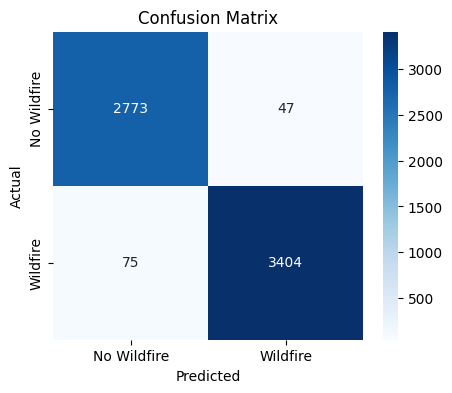

In [60]:
# Создаём confusion matrix
cm = confusion_matrix(all_labels, all_preds)
# Визуализируем
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

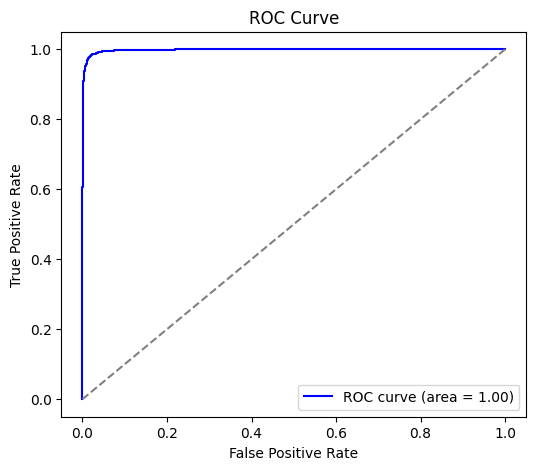

In [62]:
# Строим ROC-кривую
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Линия случайного угадывания
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()